# Feature Extraction

## N Grams features (title + artists)

In [1]:
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import re
import numpy as np

In [2]:
def sentence_to_grams(sentences):
    sentences = " ".join(sentences)
    sentence_cleaned = re.sub(r"", "", sentences)
    grams = list(sentence_cleaned)
    return grams

In [3]:
def create_dist_dict(grams, n):
    dist_dict = {}
    for i in ngrams(grams, n=n, pad_right=False, right_pad_symbol=" "):
        gram2 = "".join(i)
        dist_dict[gram2] = 0
        
    return dist_dict

In [4]:
def create_distribution(sentence, dist_dict, n):
    grams = list(sentence)
    sentence_dist = dist_dict.copy()
    for i in ngrams(grams, n=n, pad_right=False, right_pad_symbol=" "):
        gram2 = "".join(i)
        sentence_dist[gram2] += 1


    dist_values = np.array(list(sentence_dist.values()))
    dist_values = (dist_values / np.sum(dist_values))    
    
    return dist_values
    

In [143]:
sentence1 = "aa"
sentence2 = "baa"

In [144]:
def divergence(dist1, dist2):
    eps = 1e-10
    A = (dist1 + eps)/(dist2 + eps) 
    return np.sum(np.log(A)*dist1)

In [145]:
def calculate_divergence(sentence1, sentence2):
    n = 2
    dist_dict = create_dist_dict(sentence_to_grams((sentence1, sentence2)), n=n)
    dist1 = create_distribution(sentence1, dist_dict, n=n)
    dist2 = create_distribution(sentence2, dist_dict, n=n)

    return divergence(dist1, dist2)

In [146]:
calculate_divergence(sentence1, sentence2)

0.6931471804599453

<BarContainer object of 11 artists>

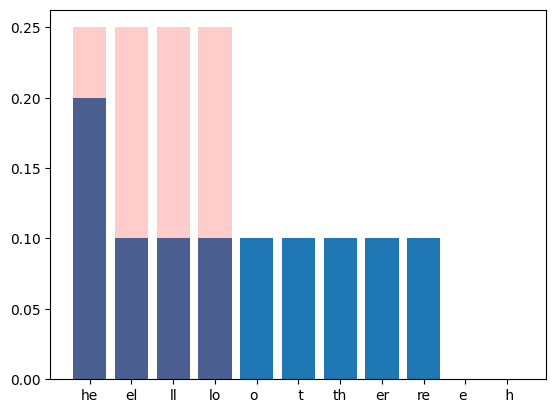

In [46]:
import matplotlib.pyplot as plt

plt.bar(x=list(dist_dict.keys()), height=dist1)
plt.bar(x=list(dist_dict.keys()), height=dist2, alpha=0.2, color="red")

## Album Cover Features

In [ ]:
import pandas as pd
import seaborn as sns
import scipy as sp

In [ ]:
import requests
from PIL import Image
import numpy as np
from io import BytesIO

image_url1 = 'https://i.scdn.co/image/ab67616d0000b27377eb7a5b9367de79c3b92a49'
image_url2 = "https://i.scdn.co/image/ab67616d0000b2733346c315c0e0e71c15ceec49"

def get_image_array_from_url(image_url):
    response = requests.get(image_url)
    
    if response.status_code == 200:
        # Open the image using PIL
        img = Image.open(BytesIO(response.content))
    
        # Convert the PIL image to a NumPy array
        img_array = np.array(img)
        
    return img_array

img_array1 = get_image_array_from_url(image_url1)
img_array2 = get_image_array_from_url(image_url2)

In [ ]:
#Get image histogram dist; can be used for entropy
image_dist1 = (np.histogram(img_array1.flatten(), bins=30, density=True))[0]
image_dist2 = (np.histogram(img_array2.flatten(), bins=30, density=True))[0]

sns.histplot(img_array1.reshape(3, -1)[2], bins=10, stat="density")

In [ ]:
def image_entropy(image_dist):
    eps = 1e-10
    return -1*np.sum(image_dist*np.log(image_dist+eps))

In [ ]:
calculate_image_features(get_image_array_from_url("https://i.scdn.co/image/ab67616d0000b27360fd902b829e5eb60812fcf2")).shape

In [ ]:
def calculate_image_features(img_array):
    if img_array.shape[-1] != 3:
        img_array = np.stack((img_array, img_array, img_array)).reshape(3, -1)
        
    
    image_dist_r = (np.histogram(img_array.reshape(3, -1)[0], bins=20, density=True))[0]
    image_dist_g = (np.histogram(img_array.reshape(3, -1)[1], bins=20, density=True))[0]
    image_dist_b = (np.histogram(img_array.reshape(3, -1)[2], bins=20, density=True))[0]
        
   

    reshaped_img = img_array.T.reshape(3, -1)
    
    rgb_mean = np.mean(reshaped_img, axis=1)
    rgb_std = np.std(reshaped_img, axis=1)
    img_cov_det = np.linalg.det(np.sqrt(np.abs(np.cov(reshaped_img))))
    img_entropy_r = image_entropy(image_dist_r)
    img_entropy_g = image_entropy(image_dist_g)
    img_entropy_b = image_entropy(image_dist_b)
    img_skewness_r = sp.stats.skew(image_dist_r)
    img_skewness_g = sp.stats.skew(image_dist_g)
    img_skewness_b = sp.stats.skew(image_dist_b)

    return sp.stats.zscore(np.array([rgb_mean[0], rgb_mean[1], rgb_mean[2], \
                                     rgb_std[0], rgb_std[1], rgb_std[2], \
                                     img_skewness_r, img_skewness_g, img_skewness_b, \
                                     img_entropy_r, img_entropy_g, img_entropy_b, \
                                     img_cov_det
                                    ]))

In [ ]:
def image_similarity(vec1, vec2):
    vec1_normalized = vec1/np.sqrt(vec1@vec1)
    vec2_normalized = vec2/np.sqrt(vec2@vec2)

    return vec1_normalized.T@vec2_normalized
    

In [ ]:
vec1 = calculate_image_features(img_array1)
vec2 = calculate_image_features(img_array2)

In [ ]:
vec2

## Release Date and Song Length
As extra features, we can also include a boolean for release date, song length and explicit. Song length especially will have high correlation with correct match. 

In [ ]:
length_1 = 189837
length_2 = 190837

release_date_1 = "2022-02-23"
release_date_2 = "2022-02-23"
explicit_1 = True
explicit_2 = True

duration_boolean = np.abs(length_1 - length_2) < 2000
release_date_boolean = release_date_1 == release_date_2
explicit_boolean = explicit_1 == explicit_2

# Labeling

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import string
import random

In [ ]:
def add_random_char_to_str(str):
    pos = random.randint(0, len(str) - 1)
    char = random.choice(string.ascii_letters)
    str_list = list(str)
    str_list[pos] = char
    
    return "".join(str_list)
    
    

In [ ]:
def add_noise_to_img(img_array):
    #return img_array
    noise = np.random.normal(loc=0, scale=2, size=img_array.shape)
#
    img_array = img_array + noise
    #
    return np.clip(img_array, 0, 255).astype(np.uint8)

#add_noise_to_img(true_track_img)

In [ ]:
data_path = os.listdir("./data2")


#plt.imshow(true_track_img)
#print("true img", true_track["img_url"])

tracks_feature_extraction = []

for path in data_path:
    
    track_df = pd.read_csv("./data2/"+path)
    
    true_track = track_df.iloc[-1]
    true_track_text = add_random_char_to_str(f"{true_track['track_name']} {true_track['album_name']} {true_track['artists']}")
    
    true_track_img = add_noise_to_img(get_image_array_from_url(true_track["img_url"]))
    
    for track in track_df.iterrows():
        track_text = add_random_char_to_str(f"{track[1]['track_name']} {track[1]['album_name']} {track[1]['artists']} {random.choice(string.ascii_letters)}")
        text_divergence = calculate_divergence(track_text, true_track_text)
        
        release_date = true_track["release_date"] == track[1]["release_date"]
        duration_boolean = np.abs(true_track["duration"] - track[1]["duration"]) < 2000

        track_img = (get_image_array_from_url(track[1]["img_url"]))
        img_sim = image_similarity(calculate_image_features(track_img), calculate_image_features(true_track_img))
    
        track_dict = {
            "text_divergence": text_divergence,
            "release_date_match": release_date,
            "duration_match": duration_boolean,
            "img_similarity": img_sim,
            "label": track[1]["label"]
        }
        
        tracks_feature_extraction.append(track_dict)
        
        


In [ ]:
extracted_data  = pd.DataFrame(tracks_feature_extraction)

In [ ]:
extracted_data.to_csv("./data/extracted_data.csv")